In [1]:
import pandas as pd
import time
import random
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Specific tf libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

In [2]:
%run ../common_utils.py
pd.set_option('display.max_colwidth', None)
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
# ALL, and building ID!
features =           ["building_id", # For grouping
                      "area_total", "area_kitchen", "area_living", "floor", "ceiling", "stories", "rooms",
                      "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed", # Numerical
                     "layout", "condition", "district", "material", "parking", "heating", "seller", #Categorical
                      "windows_court", "windows_street", "new", "elevator_without", "elevator_passenger", "elevator_service", "garbage_chute"] # Bool
                     #"street", "address"] # Strings

all_numerical_features = ["area_total", "area_kitchen", "area_living", "floor",
                      "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed"]

float_numerical_features = ["area_total", "area_kitchen", "area_living", "ceiling", "latitude", "longitude", "constructed"]
int_numerical_features = ["floor", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies", "loggias", "phones"] # Ordinal categories

cat_features = ["layout", "condition", "district", "material", "parking", "heating", "seller"] # All are non-ordinal

droptable = []

In [4]:
train, test, metaData = load_all_data()

train_labels = train[features]
test_labels = test[features]
train_targets = train['price']

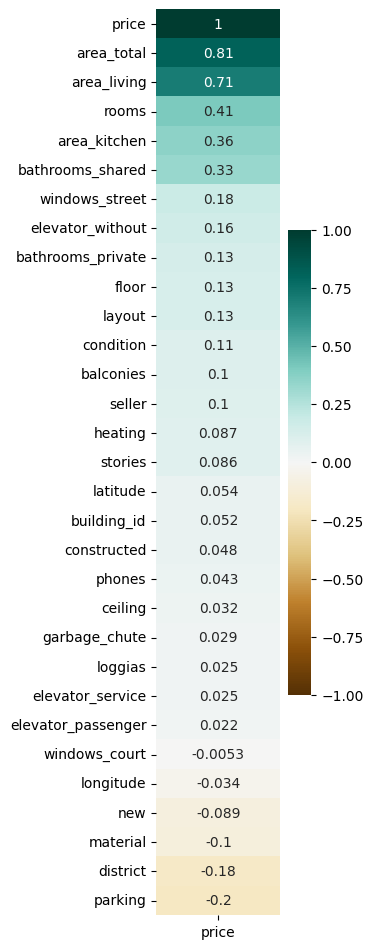

In [5]:
f, ax = plt.subplots(figsize=(2, 12), dpi=100)
heatmap = sns.heatmap(pd.merge(train[features], train["price"], left_index=True, right_index=True).corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=ax)

# DATA CLEANING
#### Log the train data

In [6]:
train_targets = np.log(train_targets)

<AxesSubplot:>

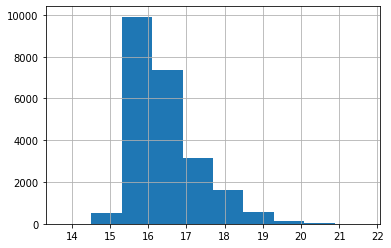

In [17]:
display(train_targets.hist())

#### Fillnan with correlated values

In [191]:
train_labels = fillnaReg(train_labels, ['area_total'], 'area_living')
test_labels = fillnaReg(test_labels, ['area_total'], 'area_living')
# Area_kitchen
train_labels = fillnaReg(train_labels, ['area_total', 'area_living'], 'area_kitchen')
test_labels = fillnaReg(test_labels, ['area_total', 'area_living'], 'area_kitchen')
# ceiling
train_labels = fillnaReg(train_labels, ['stories'], 'ceiling')
test_labels = fillnaReg(test_labels, ['stories'], 'ceiling')

#### Remove zeroes in "area living" with expected value based on area_total

In [13]:
remove_zero = [row["area_living"] if row["area_living"] >= 1 else row["area_total"]*(train_labels["area_living"].mean() / train_labels["area_total"].mean()) for _, row in train_labels.iterrows()] 
train_labels["area_living"] = remove_zero

remove_zero = [row["area_living"] if row["area_living"] >= 1 else row["area_total"]*(test_labels["area_living"].mean() / test_labels["area_total"].mean()) for _, row in test_labels.iterrows()] 
test_labels["area_living"] = remove_zero

#### Log some other values

In [14]:
fs = ["area_total", "area_living", "area_kitchen"]
for feature in fs:
    # Logging
    train_labels[feature] = np.log(train_labels[feature])
    test_labels[feature] = np.log(test_labels[feature])

## TODO - Look at these graphs and fix the diagonal line stuff

Also: are there zeroes in area_kitchen?

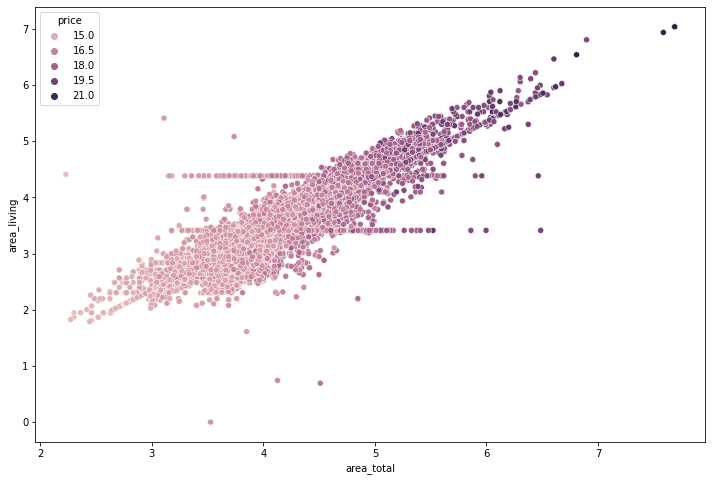

In [36]:
hue=train_targets
plt.figure(figsize=(12, 8))
sns.scatterplot(data=train_labels, x="area_total", y="area_living", hue=hue)
plt.show()

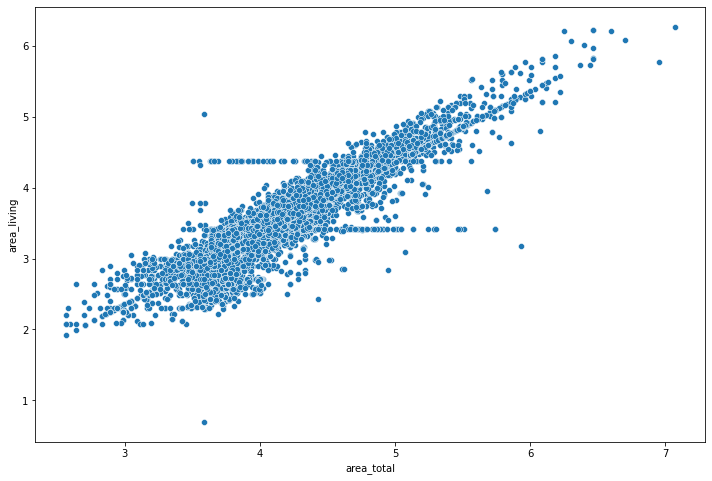

In [21]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=test_labels, x="area_total", y="area_living")
plt.show()

### TODO: use building ID to insert the long/lat!
#### Long/Lat in test data fillnan with median

In [196]:
# Insert median district
unknown_index = test_labels[["district", "latitude", "longitude"]][test_labels["latitude"].isna()==True].index
test_labels.loc[unknown_index,['district']] = test_labels["district"].median()
# Mean the long/lat
test_labels["longitude"] = test_labels["longitude"].fillna(test_labels["longitude"].mean())
test_labels["latitude"] = test_labels["latitude"].fillna(test_labels["latitude"].mean())

#### There are also 7 apartments far away from Moscow in test dataset
Problem is that we have to predict them. Fill with mean long/lat and median district. BTW they are also single apartment buildings...

In [197]:
def closest_district(lat, long):
    best_distance = -1
    closest_dist = -1
    for i in range(len(district_centre_long)):
        long_dist =  district_centre_long[i][0]
        lat_dist = district_centre_lat[i][0]
        total_dist = np.sqrt((long-long_dist)**2 + (lat-lat_dist)**2)
        if total_dist < best_distance or best_distance==-1:
            best_distance = total_dist
            closest_dist = i
    return closest_dist

In [198]:
is_outlier = (test_labels["longitude"] > 39) | (test_labels["longitude"] < 35)
outliers = test_labels.copy()[is_outlier]

unknown_index = outliers.index
test_labels.loc[unknown_index,['longitude']] = train_labels["longitude"].mean()
test_labels.loc[unknown_index,['latitude']] = train_labels["latitude"].mean()

district_centre_long = np.array(train_labels[["district", "longitude"]].groupby(['district']).mean())
district_centre_lat = np.array(train_labels[["district", "latitude"]].groupby(['district']).mean())

In [199]:
remove_nan_districts = [closest_district(row["latitude"], row["longitude"]) if math.isnan(row["district"]) else row["district"] for _, row in train_labels.iterrows()] 
train_labels["district"] = remove_nan_districts

remove_nan_districts = [closest_district(row["latitude"], row["longitude"]) if math.isnan(row["district"]) else row["district"] for _, row in test_labels.iterrows()] 
test_labels["district"] = remove_nan_districts

### Fill seller "unknown category"

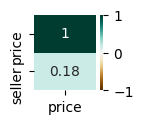

In [200]:
f, ax = plt.subplots(figsize=(1, 1), dpi=100)
heatmap = sns.heatmap(pd.merge(train_labels["seller"], train_targets, left_index=True, right_index=True).corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=ax)

In [201]:
#for feature in cat_features:
#    unknown_category = len(list(train_labels[feature].unique())) - 1
#    train_labels[feature] = train_labels[feature].fillna(unknown_category)
#    test_labels[feature] = test_labels[feature].fillna(unknown_category)
    
unknown_category = len(list(train_labels["seller"].unique())) - 1
train_labels["seller"] = train_labels["seller"].fillna(unknown_category)
test_labels["seller"] = test_labels["seller"].fillna(unknown_category)

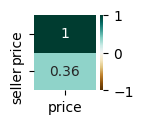

In [202]:
f, ax = plt.subplots(figsize=(1, 1), dpi=100)
heatmap = sns.heatmap(pd.merge(train_labels["seller"], train_targets, left_index=True, right_index=True).corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=ax)

### At last - Fill rest of nans using mean or median

In [203]:
# Float
train_labels[float_numerical_features] = train_labels[float_numerical_features].fillna(train_labels[float_numerical_features].mean())
# Int
train_labels[int_numerical_features] = train_labels[int_numerical_features].fillna(train_labels[int_numerical_features].median())
# Cat
train_labels[cat_features] = train_labels[cat_features].fillna(train_labels[cat_features].median())
# Bool (The rest)
train_labels = train_labels.fillna(train_labels.median()) # Boolean

# Test data preprocessing
test_labels = test[features]
# Float
test_labels[float_numerical_features] = test_labels[float_numerical_features].fillna(test_labels[float_numerical_features].mean())
# Int
test_labels[int_numerical_features] = test_labels[int_numerical_features].fillna(test_labels[int_numerical_features].median())
# Cat
test_labels[cat_features] = test_labels[cat_features].fillna(test_labels[cat_features].median())
# Bool (The rest)
test_labels = test_labels.fillna(test_labels.median()) # Boolean

# Put all cleaning in a util function

In [134]:
# ALL, and building ID!
features =           ["building_id", # For grouping
                      "area_total", "area_kitchen", "area_living", "floor", "ceiling", "stories", "rooms",
                      "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed", # Numerical
                     "layout", "condition", "district", "material", "parking", "heating", "seller", #Categorical
                      "windows_court", "windows_street", "new", "elevator_without", "elevator_passenger", "elevator_service", "garbage_chute"] # Bool
                     #"street", "address"] # Strings

all_numerical_features = ["area_total", "area_kitchen", "area_living", "floor",
                      "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed"]

float_numerical_features = ["area_total", "area_kitchen", "area_living", "ceiling", "latitude", "longitude", "constructed"]
int_numerical_features = ["floor", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies", "loggias", "phones"] # Ordinal categories

cat_features = ["layout", "condition", "district", "material", "parking", "heating", "seller"] # All are non-ordinal

droptable = []

In [135]:
%run ../common_utils.py
train, test, metaData = load_all_data()
train_labels, train_targets, test_labels = clean_data(train, test, features, float_numerical_features, int_numerical_features, cat_features,log_targets=True, log_area=True, fillNan=False)

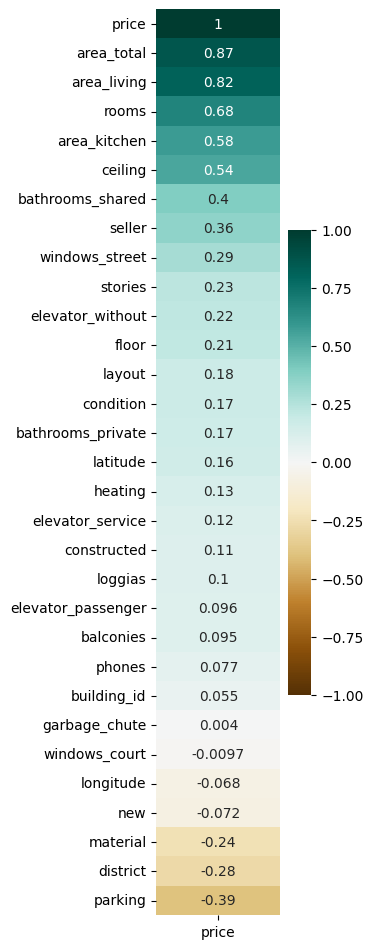

In [126]:
f, ax = plt.subplots(figsize=(2, 12), dpi=100)
heatmap = sns.heatmap(pd.merge(train_labels, train_targets, left_index=True, right_index=True).corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=ax)

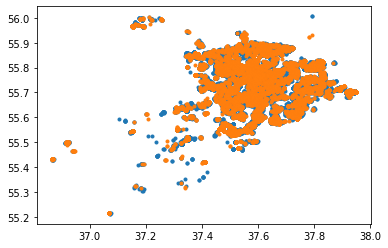

In [127]:
plt.plot(train_labels["longitude"], train_labels["latitude"], ".")
plt.plot(test_labels["longitude"], test_labels["latitude"], ".")
plt.show()

# Feature engineering

Some other ideas:
- Plot price vs phones. Maybe 0 bad, 1 good, 2 bad?
- Balconies and other ordinal data: fill with unknown value, like for categorical "seller"! Then make "has_balcony" feature.

In [136]:
%run ../common_utils.py

In [147]:
my_own_features =[]
# Add R and theta
train_labels, test_labels = polar_coordinates(train_labels, test_labels)
#float_numerical_features.append("r")
my_own_features.append("r")
my_own_features.append("theta")

# ADD rel_height of apartment
train_labels['rel_height'] = train_labels["floor"] / train_labels["stories"]
test_labels['rel_height'] = test_labels["floor"] / test_labels["stories"]
my_own_features.append('rel_height')

# Add "Spacious_rooms": area per room
train_labels['spacious_rooms'] = train_labels['area_total'] / train_labels['rooms']
test_labels['spacious_rooms'] = test_labels['area_total'] / test_labels['rooms']
my_own_features.append('spacious_rooms')

# Newly_built
is_new = [1 if row["constructed"] >= 2000 else 0 for _, row in train_labels.iterrows()] 
train_labels["actually_new"] = is_new

is_new = [1 if row["constructed"] >= 2000 else 0 for _, row in test_labels.iterrows()] 
test_labels["actually_new"] = is_new
my_own_features.append("actually_new")


In [148]:
### Testing some new ideas!
train_labels["rel_kitchen"] = train_labels["area_kitchen"] / train_labels["area_total"]
test_labels["rel_kitchen"] = test_labels["area_kitchen"] / test_labels["area_total"]
my_own_features.append("rel_kitchen")

train_labels["rel_living"] = train_labels["area_living"] / train_labels["area_total"]
test_labels["rel_living"] = test_labels["area_living"] / test_labels["area_total"]
my_own_features.append("rel_living")
    
train_labels["total_bathrooms"] = train_labels["bathrooms_private"] + train_labels["bathrooms_shared"]
test_labels["total_bathrooms"] = test_labels["bathrooms_private"] + test_labels["bathrooms_shared"]
my_own_features.append("total_bathrooms")

In [150]:
### BAD
##New features: only one phone
#train_labels["one_phone"] = (train_labels["phones"]==1)
#my_own_features.append("one_phone")
##New features: Penthouse
#train_labels["penthouse"] = (train_labels["stories"]>5) & (train_labels["stories"]==train_labels["floor"])
#my_own_features.append("penthouse")
#print(len(train_labels[["penthouse","stories","floor"]][train_labels["penthouse"]==1]))
##New features: has balconies, solo apartment, ancient mansion, only one phone etc.
#train_labels["has_balconies"] = (train_labels["balconies"]!=0)
#my_own_features.append("has_balconies")

In [208]:
# New feature multiple balconies
my_own_features =[]
train_labels["multiple_balconies"] = (train_labels["balconies"]>1)
my_own_features.append("multiple_balconies")

In [209]:
#New features: has balconies, solo apartment, ancient mansion, only one phone etc.
train_labels["multiple_loggias"] = (train_labels["loggias"]>1)
my_own_features.append("multiple_loggias")

In [210]:
#New features: has balconies, solo apartment, ancient mansion, only one phone etc.
train_labels["both_windows"] = (train_labels["windows_court"]==True) & (train_labels["windows_street"]==True)
my_own_features.append("both_windows")

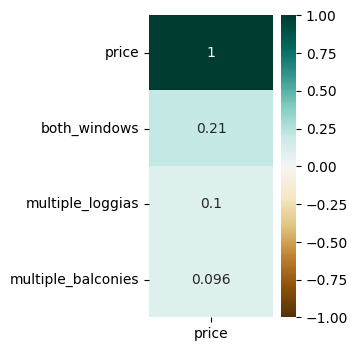

In [211]:
f, ax = plt.subplots(figsize=(2, 4), dpi=100)
heatmap = sns.heatmap(pd.merge(train_labels[my_own_features], train_targets, left_index=True, right_index=True).corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=ax)
#heatmap = sns.heatmap(pd.merge(train_labels, train_targets, left_index=True, right_index=True).corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=ax)

# One-hot encoding

In [177]:
pass

# Normalize float numerical data
And also, should we normalize the integer data?

In [48]:
# Choose scaler
scaler = "minMax"

# Only normalize/scale the numerical data. Categorical data is kept as is.
train_labels_n = train_labels.filter(float_numerical_features)
test_labels_n = test_labels.filter(float_numerical_features)

# Scale it.
if scaler=="minMax":
    print("minMax")
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_labels_scaled = scaler.fit_transform(train_labels_n)
    test_labels_scaled = scaler.transform(test_labels_n)
elif scaler=="std":
    print("Std")
    std_scale = preprocessing.StandardScaler().fit(train_labels_n)
    train_labels_scaled = std_scale.transform(train_labels_n)
    test_labels_scaled = std_scale.transform(test_labels_n)
else:
    assert ValueError, "Incorrect scaler"

# Re-enter proceedure
training_norm_col = pd.DataFrame(train_labels_scaled, index=train_labels_n.index, columns=train_labels_n.columns) 
train_labels.update(training_norm_col)

testing_norm_col = pd.DataFrame(test_labels_scaled, index=test_labels_n.index, columns=test_labels_n.columns) 
test_labels.update(testing_norm_col)

minMax


<AxesSubplot:>

<AxesSubplot:>

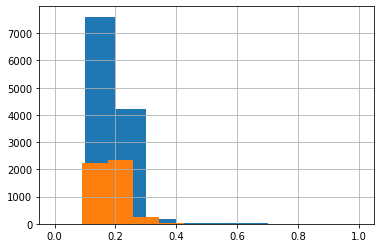

In [56]:
display(train_labels["ceiling"].hist())
display(test_labels["ceiling"].hist())

### Drop heavily correlated and also nan-ridden features.

In [180]:
#droptable = ["bathrooms_private", "bathrooms_shared","longitude", "latitude", "rel_kitchen", "area_kitchen", "area_living",  # Dropped cuz they correlate too much with other features
#            "theta", "rel_height", "loggias", "elevator_passenger", "layout", "phones", "rel_height", "windows_court", "balconies", "garbage_chute", "new",  # Dropped cuz they suck
#             ]

In [181]:
## Drop the most correlated features.
#train_labels.drop(droptable, inplace=True, axis=1)
#test_labels.drop(droptable, inplace=True, axis=1)

In [182]:
#f, ax = plt.subplots(figsize=(2, 8), dpi=100)
#heatmap = sns.heatmap(pd.merge(train_labels, train_targets, left_index=True, right_index=True).corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=ax)

### BUT? Does the model really improve from this??

In [112]:
import xgboost
from xgboost import plot_importance
%run ../common_utils.py

In [113]:
#xgb_model = xgboost.XGBRegressor(max_depth=5, min_child_weight=12, gamma=0.15, subsample=0.8, colsample_bytree=0.8, reg_alpha=1.1, reg_lambda=0.3, learning_rate=0.01, n_estimators=10000)
model_params = [5, 12, 0.15, 0.8, 0.8, 1.1, 0.3, 0.01, 10000]

In [114]:
# We are passing targets as log, as we dont have a rmsle loss, only an rmse
scores, avg, best_model, models = XGB_groupKFold(5, model_params, train_labels, train_targets,
    eval_metric='rmse')

In [115]:
print(scores)
print("=>",avg)

[0.20460543543119916, 0.17765711850847754, 0.19425070871965808, 0.18429857318387216, 0.23786591465009785]
=> 0.19973555009866098


### Some results
- with all cleaned features, nothing else:    0.2067834723823633
- ... also scaling the float features;        0.206183900882532
- No cleaning, no nothing. (XGB got it)       0.20585560351182436
- Using the std scaler instead:               0.20621786410814194
- Adding rel_h, r, theta, spacious, new_new:  0.20084688206867568
- Removing a lot of features!                 0.21543669415934047 :(
- One - hotting?
- Just adding features not removing any:      0.18511!

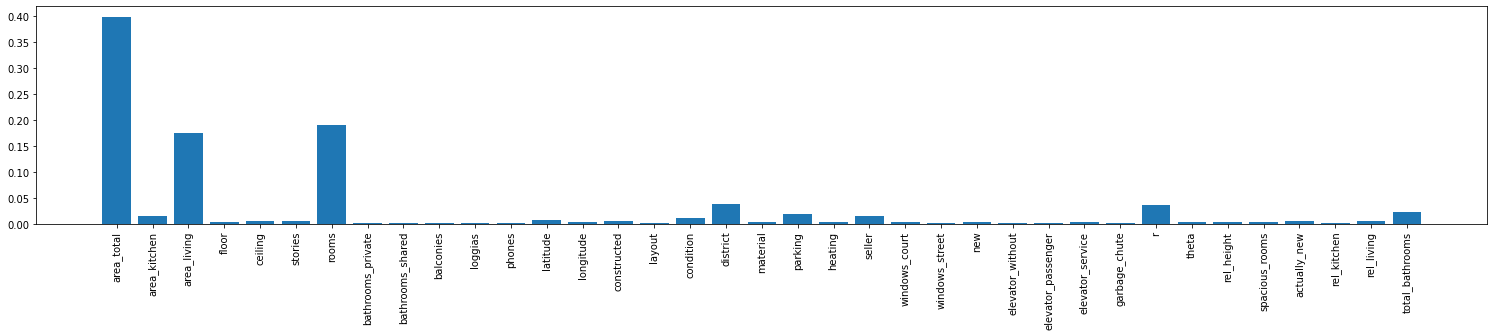

In [61]:
plt.figure(figsize=(26, 4))
plt.bar(train_labels.drop(["building_id"], axis=1).columns.tolist(), best_model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

In [62]:
# eda_test_0: got a super duper kaggle score: 0.187!

In [64]:
#predict_and_store(best_model, test_labels.drop(["building_id"], axis=1), test, path="boosting_predictions/eda_test_0", exponential=True)
for i in range(5):
    predict_and_store(models[i], test_labels.drop(["building_id"], axis=1), test, path="boosting_predictions/new_features_"+str(i), exponential=True)